In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd

sys.path.insert(0, '../src/data')
sys.path.insert(0, '../src/features')
sys.path.insert(0, '../src/models')
sys.path.insert(0, '../src/visualization')

from data_manager import DataManager
from pretreatment import create_superclasses

from ada_boost import AdaBoost
from decision_tree import DecisionTree
from k_means import KMeans
from svm import Svm
from neural_network import NeuralNetwork
from perceptron import Perceptron

from visualize import Visualize

## Prétraitement des données

In [3]:
raw_path = '../data/raw/train.csv'
test_path = '../data/raw/test.csv'
superclasses_path = '../data/processed/superclasses.csv'
normalized_path = '../data/processed/data_normalisee.csv'
no_outliers_path = '../data/processed/data_no_outliers_1%.csv'
no_outliers_normalized_path = '../data/processed/data_without_outliers_and_normalized.csv'
pca_path = '../data/processed/data_pca.csv'

In [4]:
rawDataset = DataManager(raw_path, "Raw dataser")
# testDataset = DataManager(test_path, "Test dataset")
superclassesDataset = DataManager(superclasses_path, "Superclasses")
normalizedDataset = DataManager(normalized_path, "Normalized")
noOutliersDataset = DataManager(no_outliers_path, "No outliers")
noOutliersNormalizedDataset = DataManager(no_outliers_normalized_path, "No outliers and normalized")
pcaDataset = DataManager(pca_path, "PCA")

Création des superclasses : 

In [5]:
# create_superclasses(raw_path, superclasses_path)

## Chargement des données

In [55]:
# Choix du dataset
dataset = rawDataset

In [19]:
dataset.constants.print(labels=False)

print(f"x_train.shape: {dataset.x_train.shape}")
print(f"x_test.shape: {dataset.x_test.shape}")
print(f"t_train.shape: {dataset.t_train.shape}")
print(f"t_test.shape: {dataset.t_test.shape}")

n_labels   = 99
n_features = 192
n_samples  = 990
x_train.shape: (792, 192)
x_test.shape: (198, 192)
t_train.shape: (792,)
t_test.shape: (198,)


## Préparation du modèle

In [20]:
PerceptronModel = Perceptron()
NeuralNetworkModel = NeuralNetwork()
AdaBoostModel = AdaBoost()
SvmModel = Svm()
DecisionTreeModel = DecisionTree()
KMeansModel = KMeans(dataset.constants.get_n_labels())

In [44]:
# model = PerceptronModel
# model = NeuralNetworkModel
model = AdaBoostModel
# model = SvmModel
# model = DecisionTreeModel
# model = KMeansModel
hyperparameters_choices = model.get_hyperparameters_choices()

## Apprentissage du modèle

In [45]:
# Enable to take random hyperparameters
hyperparameters = model.get_alea_hyperparameters(hyperparameters_choices)
print(f"hyperparameters: {hyperparameters}")

hyperparameters: {'n_estimators': 287, 'learning_rate': 0.025, 'algorithm': 'SAMME'}


In [46]:
best_hyperparameters = model.find_optimal_hyperparameters(dataset.x_train, dataset.t_train, hyperparameters_choices)
print(f"Les meilleurs hyperparameters: {best_hyperparameters}")

Les meilleurs hyperparameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.037, 'n_estimators': 287}


In [47]:
model.train(dataset.x_train, dataset.t_train, best_hyperparameters)

## Tests et visualisation

In [48]:
t_pred = model.predict(dataset.x_test)
t_pred_proba = model.predict_proba(dataset.x_test)

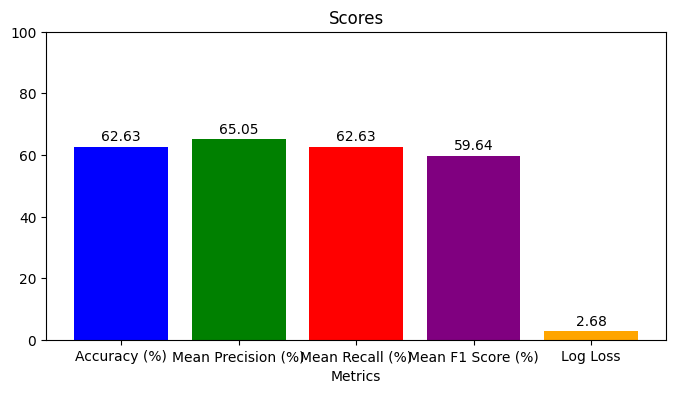

In [49]:
visualize = Visualize(dataset.constants, dataset.t_test, t_pred, t_pred_proba, dataset.name)
visualize.plot_mean_scores(title="Scores")

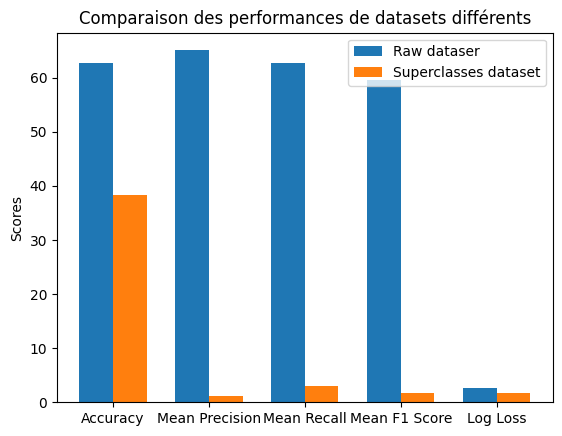

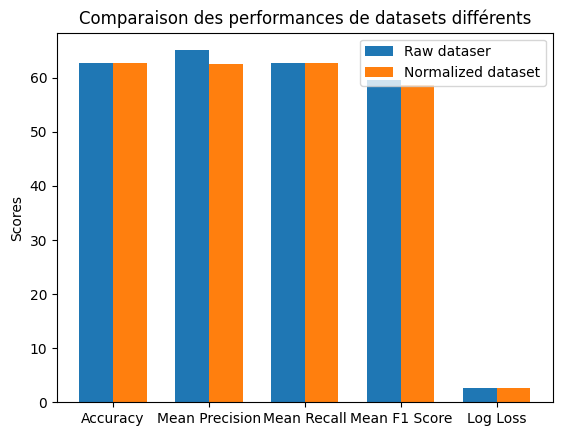

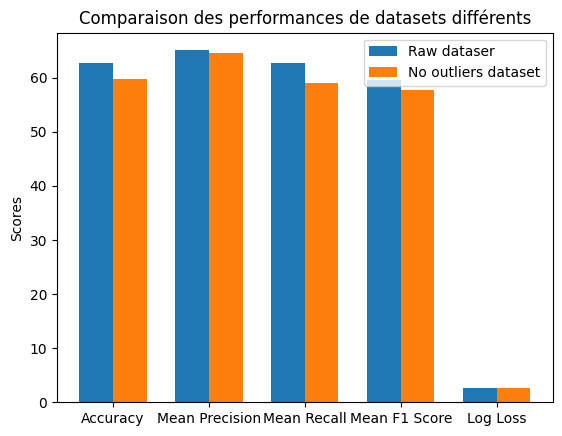

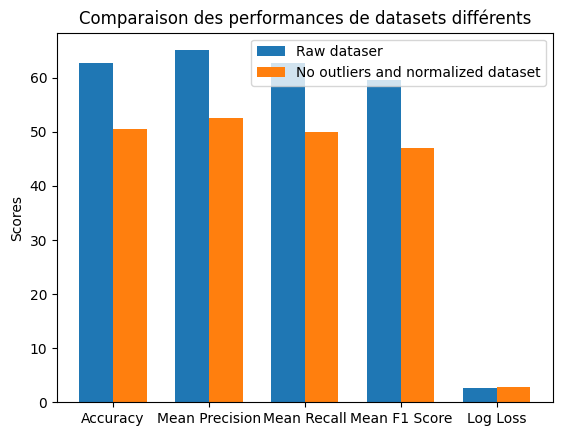

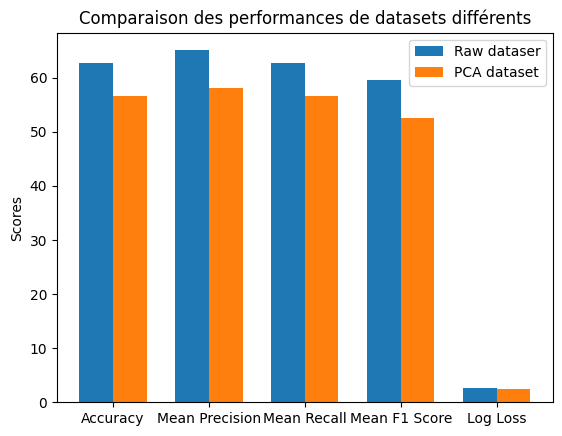

In [50]:
for compDataset in [superclassesDataset, normalizedDataset, noOutliersDataset, noOutliersNormalizedDataset, pcaDataset]:
	model.train(compDataset.x_train, compDataset.t_train, best_hyperparameters)
	comp_t_pred = model.predict(compDataset.x_test)
	comp_t_pred_proba = model.predict_proba(compDataset.x_test)
	compVisualize = Visualize(compDataset.constants, compDataset.t_test, comp_t_pred, comp_t_pred_proba, compDataset.name)
	visualize.plot_mean_scores(compVisualize, title="Comparaison des performances de datasets différents")


### Comparaison avec/sans Paramètres optimaux

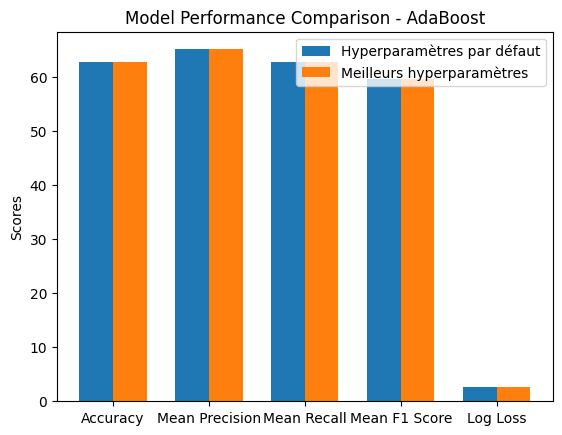

In [51]:
# Entraînement avec des hyperparamètres par défaut
model.train(dataset.x_train, dataset.t_train, {})  # Hyperparamètres vides signifient les valeurs par défaut

# Test et évaluation avec hyperparamètres par défaut
t_pred_default = model.predict(dataset.x_test)
t_pred_proba_default = model.predict_proba(dataset.x_test)
visualize_default = Visualize(dataset.constants, dataset.t_test, t_pred_default, t_pred_proba_default, "Hyperparamètres par défaut")

# Entraînement avec des hyperparamètres optimisés
model.train(dataset.x_train, dataset.t_train, best_hyperparameters)

# Test et évaluation avec hyperparamètres optimisés
visualize_optimized = Visualize(dataset.constants, dataset.t_test, t_pred, t_pred_proba, "Meilleurs hyperparamètres")
model_name = model.__class__.__name__
visualize_default.plot_mean_scores(visualize_optimized, title=f"Model Performance Comparison - {model_name}")


<module 'matplotlib.pyplot' from "/home/timwhity/Documents/0_Sherbrooke/CoursSherbrooke/IFT712-Technique d'apprentissage/TPOussama/Projet/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py">

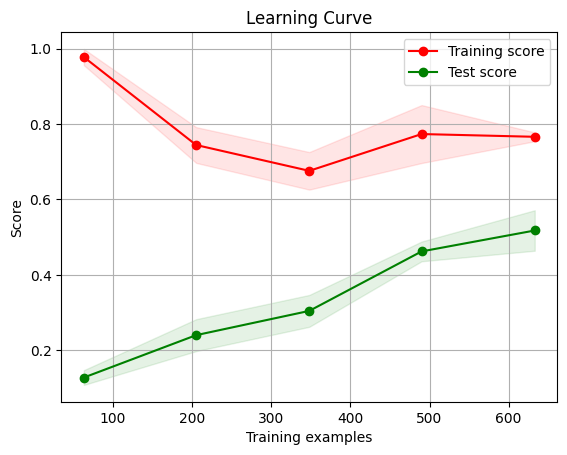

In [52]:
Visualize.plot_learning_curve(model.model, "Learning Curve", dataset.x_train, dataset.t_train, cv=5)

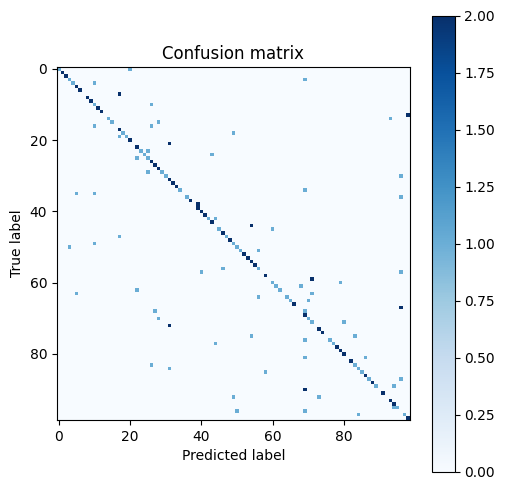

In [53]:
visualize.plot_confusion_matrix(show_label=False)
# visualize.plot_confusion_matrix(show_label=True)

## Enregistrement des output des données de test

You must submit a csv file with the image id, all candidate species names, and a probability for each species. The order of the rows does not matter. The file must have a header and should look like the following:

```
id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,...
2,0.1,0.5,0,0.2,...
5,0,0.3,0,0.4,...
6,0,0,0,0.7,...
etc.
```

In [43]:
# Predict Test Set
clf = model.model
test = pd.read_csv('../data/raw/test.csv')

# Remove the "id" column from the test data
test_no_id = test.drop(['id'], axis=1)

test_predictions = clf.predict_proba(test_no_id)
classes = list(dataset.constants.get_labels())

# Format DataFrame
submission = pd.DataFrame(test_predictions, columns=classes)
submission.insert(0, 'id', test.id)
submission.reset_index()

# Export Submission
submission.to_csv(f'../data/submissions/submission_{clf}.csv', index=False)
submission.tail()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
589,1576,2.327688e-08,9.970342e-01,9.865697e-10,4.658691e-11,2.978475e-04,8.875683e-14,1.689387e-10,2.615218e-10,2.458211e-04,...,5.129117e-12,1.053836e-16,2.624556e-11,6.489765e-13,3.486130e-12,9.041983e-08,1.704381e-09,7.221686e-18,7.216666e-17,2.989825e-05
590,1577,1.282768e-08,3.169586e-06,3.135209e-15,2.519037e-06,1.565957e-13,8.209497e-19,4.559910e-09,2.487665e-12,3.522927e-06,...,1.238579e-11,1.069497e-14,9.320172e-06,1.302455e-11,1.579877e-04,4.372467e-03,1.994467e-05,1.971759e-13,7.585581e-13,1.788884e-05
591,1579,3.487257e-08,3.437638e-08,2.929035e-09,4.236983e-09,7.200249e-11,1.058369e-11,9.362931e-12,2.794651e-16,3.465188e-13,...,2.974300e-17,1.465286e-13,1.156097e-13,2.439304e-12,3.041079e-13,2.149856e-13,3.940466e-18,8.734997e-09,6.362502e-13,3.050173e-07
592,1580,1.618881e-13,2.011736e-10,1.043327e-05,4.508238e-08,1.806764e-10,7.005192e-10,1.825907e-09,1.010022e-05,1.418123e-12,...,1.488611e-08,9.119515e-08,4.409238e-17,7.232884e-04,2.119090e-12,1.585527e-08,2.578686e-16,4.667733e-11,1.255711e-15,9.466099e-09
593,1583,1.803870e-27,5.714532e-11,1.066224e-09,1.001741e-13,6.353277e-17,4.584716e-08,3.747436e-06,2.643520e-23,4.517459e-22,...,4.424982e-23,1.374000e-16,2.391918e-23,6.886084e-19,3.545208e-20,4.374283e-18,5.523820e-26,7.465988e-12,4.012032e-19,1.795760e-12
